In [8]:
#!/usr/bin/python

#import necessary modules
from pyhdf import SD
import numpy as np
import math
from mpl_toolkits.basemap import Basemap, cm
import matplotlib.pyplot as plt
import MisrToolkit as Mtk
import sys
import glob
import h5py
import time
import datetime
import calendar
import scipy
from scipy import spatial
from regrid_cats_cth import regrid_cats
from pyhdf.SD import SD,SDC

#Nearest-neighbour search routine
def do_kdtree(A, pt):
    mytree = scipy.spatial.cKDTree(A,balanced_tree=False,compact_nodes=False)
    dist, indexes = mytree.query(pt,distance_upper_bound=np.inf)
    return indexes

#Calculate physical distance between two geographical coordinates
def haversine(coord1, coord2):
    R = 6372800  # Earth radius in meters
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

CTH_CATS = np.zeros((360,720))
CTH_MISR = np.zeros((360,720))
CTH_MODIS = np.zeros((360,720))
CTH_diff = np.zeros((360,720))
count = np.zeros((360,720))
#count[:,:] = 1
myfile = open('CATS_MODIS_coincidence_backscatter_statitics_Aug_2017_1', 'w')
myfile2 = open('CATS_height_MISR_no_retreival_MODIS_statistics_Aug_2017_1','w')
#myfile3 = open('CATS_collocated_coordinate_points_Aug_2017', 'w')
MODIS_DATAFIELD_NAME = 'cloud_top_height_1km'

#open files in loop for reading
FILE_NAME=sorted(glob.glob('./CATS/Aug_2017/*.hdf5'))
MISR_DIRECTORY='/data/keeling/a/arkam2/b/MISR/Aug_2017/'
for i in range(14,15):
    try:
        hdf = h5py.File(FILE_NAME[i], 'r')
        print("Operating on CATS orbit:", FILE_NAME[i])
        y = FILE_NAME[i]
    except:
        continue


#Get latitude and longitude
    geolocation = hdf['geolocation']
    lat = geolocation['CATS_Fore_FOV_Latitude']
    latitude = lat[:,2] #have a shape of (3838,3) of combined 3 orbits
    lon = geolocation['CATS_Fore_FOV_Longitude']
    longitude = lon[:,2]
    metadata_parameters = hdf['metadata_parameters']
    altitude = metadata_parameters['Bin_Altitude_Array'][()]
#print(np.shape(longitude))

    optical_properties = hdf['profile']
    name = 'Feature_Type_Fore_FOV'
    feature_type = optical_properties[name]
    backscatter = optical_properties['Particulate_Backscatter_Coefficient_1064_Fore_FOV']
    cld_phase = optical_properties['Cloud_Phase_Fore_FOV']
    print(np.shape(feature_type))
    UTC_time = optical_properties['Profile_UTC_Time']

#Now time to isolate the date time information from CATS filename to figure out
#MISR and MODIS paths that coincide with the CATS orbit
    orbit_date=(y[50:60])
    start_time=(y[60:69]).replace('-',':')
    end_time=(y[69:78]).replace('-',':')
    start_time=orbit_date+start_time
    end_time=orbit_date+end_time
    #print(start_time,end_time)

#Find out the MISR list of orbits that fall within the time range of CATS orbit
    try:
        MISR_orbits = Mtk.time_range_to_orbit_list(start_time,end_time)
        print(MISR_orbits)
    except:
        continue

    for j in range(0,len(MISR_orbits)):
        MISR_path=Mtk.orbit_to_path(MISR_orbits[j])
        print(MISR_path)
        if MISR_path<10:
            path=str(0)+str(0)+str(MISR_path)
        elif (MISR_path<100) & (MISR_path>9):
            path=str(0)+str(MISR_path)
        else:
            path=str(MISR_path)
        MISR_file = MISR_DIRECTORY+'MISR_AM1_TC_CLOUD_P'+path+'_O0'+str(MISR_orbits[j])+'_F01_0001.hdf'
        print(MISR_file)
        try:
            mt = Mtk.MtkFile(MISR_file)
        except:
            continue
        block_num_time = np.array(mt.block_metadata_field_read('PerBlockMetadataTime', 'BlockCenterTime'))
        block_num_list = np.array(mt.block_metadata_field_read('PerBlockMetadataCommon', 'Block_number'))
        block_num_list = block_num_list[np.logical_and(block_num_time[:]!='',block_num_time[:]!='0000-00-00T00:00:00.000000Z')]
        block_num_time = block_num_time[np.logical_and(block_num_time[:]!='',block_num_time[:]!='0000-00-00T00:00:00.000000Z')]
        hr = np.zeros(len(block_num_list))
        mins = np.zeros(len(block_num_list))
        #print(block_num_time)
        for a in range(0,len(block_num_time)):
            #print(block_num_time[k][14:16])
            yr=int(block_num_time[a][0:4])
            mn=int(block_num_time[a][5:7])
            dy=int(block_num_time[a][8:10])
            hr[a]=int(block_num_time[a][11:13])
            mins[a]=int(block_num_time[a][14:16])
            #print(block_num_time[a])
            #print(yr,mn,dy,(hr[a]),mins[a])
        for k in range(0, len(latitude)): #upto len(latitude)
            #print("Yahoo!")
            CATS_time = UTC_time[k,1]
            CATS_lat = latitude[k]
            CATS_long = longitude[k]
            CATS_coord = [CATS_lat,CATS_long]
            CATS_profile = feature_type[:,k]
            CATS_backscatter = backscatter[:,k]
            phase = cld_phase[:,k]
            #print(np.shape(CATS_coord))
            #print(CATS_lat,CATS_long)
            Hours = (CATS_time*24)%24
            Minutes = (Hours%1)*60
            Seconds = (Minutes%1)*60
            #print("CATS : %d:%02d:%02d" % (Hours, Minutes, Seconds))
            Minutes = int(Minutes)
            Hours = int(Hours)
            if (Minutes==1):
                start_time_window_min=59
                start_time_window_hr=Hours-1
                end_time_window_min=Minutes+2
                end_time_window_hr=Hours
            elif (Minutes==2):
                start_time_window_min=0
                start_time_window_hr=Hours
                end_time_window_min=Minutes+2
                end_time_window_hr=Hours
            elif (Minutes==59):
                start_time_window_min=Minutes-2
                start_time_window_hr=Hours
                end_time_window_min=1
                end_time_window_hr=Hours+1
            elif (Minutes==58):
                start_time_window_min=Minutes-2
                start_time_window_hr=Hours
                end_time_window_min=0
                end_time_window_hr=Hours+1
            else:
                start_time_window_min=Minutes-2
                start_time_window_hr=Hours
                end_time_window_min=Minutes+2
                end_time_window_hr=Hours
            #print(start_time_window_hr,start_time_window_min)
            #print(end_time_window_hr,end_time_window_min)
            try:
                start_block = np.min(block_num_list[np.logical_and(hr==start_time_window_hr,mins==start_time_window_min)])
                end_block = np.max(block_num_list[np.logical_and(hr==end_time_window_hr,mins==end_time_window_min)])
            except:
                continue
            #print(start_block,end_block)
            num_blocks = end_block-start_block
            geog_dist = np.zeros(num_blocks)
            #print(num_blocks)
            for l in range(start_block,end_block):
                #print("Yahoo!")
                r = Mtk.MtkRegion(MISR_path, l,l)
                center_coord = r.center
                #print((center_coord))
                geog_dist[l-start_block] = haversine(CATS_coord,center_coord)/1000.0

            if (np.min(geog_dist)<=380.0):
                r = Mtk.MtkRegion(MISR_path, start_block, end_block)
                map_info = r.snap_to_grid(MISR_path, 1100)
                latlon = np.asarray(map_info.create_latlon())
                lat = latlon[0,:,:]
                lon = latlon[1,:,:]
                ydata=np.shape(lat)[1]
                xdata=np.shape(lon)[0]
                ncoll=xdata*ydata
                #print(xdata,ydata)
                misr_points = ([lat.ravel(), lon.ravel()])
                d = mt.grid('Stereo_1.1_km').field('CloudTopHeight').read(r)
                misr_collocated = (d.data()*0.001).ravel()
                #print(np.shape(misr_points))
                CM_collocation = do_kdtree(np.transpose(misr_points),CATS_coord)
                #MISR_point = int(CM_collocation)
                nn_MISR_lat = misr_points[0][CM_collocation]
                nn_MISR_long = misr_points[1][CM_collocation]
                nn_MISR = [nn_MISR_lat,nn_MISR_long]
                print("CATS: ",CATS_lat,CATS_long)
                print("MISR: ",nn_MISR_lat,nn_MISR_long)
                if (abs(nn_MISR_lat-CATS_lat)<=0.1) and (abs(nn_MISR_long-CATS_long)<=0.1) and \
                   (nn_MISR_lat != -200.0) and (nn_MISR_long != -200.0):
                        #print(start_block,end_block)
                        try:
                            CATS_height = altitude[np.min(np.where(CATS_profile==1))]
                            CATS_scatter = CATS_backscatter[np.min(np.where(CATS_profile==1))]
                            CATS_phase = phase[np.min(np.where(CATS_profile==1))]
                            MISR_height = misr_collocated[CM_collocation]
                            divisible=start_time_window_min%5
                            start_time_window_min = start_time_window_min-divisible
                            #print("tdelta = ",tdelta)
                            if start_time_window_min==0:
                                start_time_window_min=0
                                start_time_window_hr=start_time_window_hr-1
                            #s1=start_time[11:14]+str(start_time_window_min)+':00'
                            divisible = end_time_window_min%5
                            end_time_window_min = end_time_window_min+(5-divisible)
                            if end_time_window_min==60:
                                end_time_window_min=0
                                end_time_window_hr=end_time_window_hr+1
                            #print(end_time_window_hr,end_time_window_min,start_time_window_hr,start_time_window_min)
                            if start_time_window_hr==end_time_window_hr-1:
                                tdelta=(60-start_time_window_min)+end_time_window_min
                                intervals=tdelta/5
                            else:
                                tdelta=end_time_window_min-start_time_window_min
                                intervals=tdelta/5
                            #print(intervals)
                            #print(yr,mn,dy1,hr1,mins1)
                            #print(dy2,hr2,mins2)
                            #print(mins1,mins2)
                            mod_data=[]
                            mod_lat=[]
                            mod_lon=[]
                            dy11=datetime.datetime.strptime(str(datetime.date(yr,mn,dy)),'%Y-%m-%d').timetuple().tm_yday
                            #print(dy11)
                            if dy11<10:
                                day=str(0)+str(0)+str(dy11)
                            if dy11<100:
                                day=str(0)+str(dy11)
                            else:
                                day=str(dy11)
                            if start_time_window_min<10:
                                mint=str(0)+str(start_time_window_min)
                            else:
                                mint=str(start_time_window_min)
                            if start_time_window_hr<10:
                                hour=str(0)+str(start_time_window_hr)
                            else:
                                hour=str(start_time_window_hr)
                            MOD=str(yr)+day
                            #print('/data/keeling/a/arkam2/c/MODIS/MOD06_L2/Aug_2017/MOD06_L2/2017/'+day+'/MOD06_L2.A'+str(yr)+day+'.'+hr+mint+'*.hdf')
                            MOD06_file=sorted(glob.glob('/data/keeling/a/arkam2/c/MODIS/MOD06_L2/Aug_2017/MOD06_L2/2017/'+day+'/MOD06_L2.A'+str(yr)+day+'.'+hour+mint+'*.hdf'))[0]
                            MOD03_file=sorted(glob.glob('/data/keeling/a/arkam2/b/MODIS/MOD03/Aug_2017/MOD03/2017/'+day+'/MOD03.A'+str(yr)+day+'.'+hour+mint+'*.hdf'))[0]
                            #print('Now calculating NN points for the MODIS granule files------->')
                            print(MOD03_file)
                            hdf = SD(MOD06_file, SDC.READ)
                            data_selected_id = hdf.select(MODIS_DATAFIELD_NAME)
                            data1 = data_selected_id.get()
                            data2=data1.ravel()
                            data1_selected_attributes = data_selected_id.attributes()
                            fillvalue = data1_selected_attributes['_FillValue']
                            #data1[data1 == fillvalue] = 0
                            data1 = data1 * 0.001
                            hdf_geo = SD(MOD03_file, SDC.READ)
                            lati = hdf_geo.select('Latitude')
                            latit = lati[:,:]
                            long = hdf_geo.select('Longitude')
                            longit = long[:,:]
                            mod_data=np.append(mod_data,data1.ravel())
                            mod_lat=np.append(mod_lat,latit.ravel())
                            mod_lon=np.append(mod_lon,longit.ravel())
                            #print(np.max(mod_data))
                            if (start_time_window_min==55):
                                    mint='00'
                                    if (start_time_window_hr<9):
                                        hour='0'+str(start_time_window_hr+1)
                                    else:
                                        hour=str(start_time_window_hr+1)
                            if (start_time_window_min==0):
                                    mint='05'
                            else:
                                    mint=str(start_time_window_min+5)
                            #print(hour,mint)
                            #print('/data/keeling/a/arkam2/c/MODIS/MOD06_L2/Aug_2017/MOD06_L2/2017/'+day+'/MOD06_L2.A'+str(yr)+day+'.'+hour+mint+'*.hdf')
                            MOD06_file=sorted(glob.glob('/data/keeling/a/arkam2/c/MODIS/MOD06_L2/Aug_2017/MOD06_L2/2017/'+day+'/MOD06_L2.A'+str(yr)+day+'.'+hour+mint+'*.hdf'))[0]
                            MOD03_file=sorted(glob.glob('/data/keeling/a/arkam2/b/MODIS/MOD03/Aug_2017/MOD03/2017/'+day+'/MOD03.A'+str(yr)+day+'.'+hour+mint+'*.hdf'))[0]
                            #print('Now calculating NN points for the MODIS granule file------->')
                            print(MOD03_file)
                            hdf = SD(MOD06_file, SDC.READ)
                            data_selected_id = hdf.select(MODIS_DATAFIELD_NAME)
                            data1 = data_selected_id.get()
                            data2=data1.ravel()
                            data1_selected_attributes = data_selected_id.attributes()
                            fillvalue = data1_selected_attributes['_FillValue']
                            #data1[data1 == fillvalue] = 0
                            data1 = data1 * 0.001
                            data2=data1.ravel()
                            hdf_geo = SD(MOD03_file, SDC.READ)
                            lati = hdf_geo.select('Latitude')
                            latit = lati[:,:]
                            long = hdf_geo.select('Longitude')
                            longit = long[:,:]
                            mod_data=np.append(mod_data,data2)
                            mod_lat=np.append(mod_lat,latit.ravel())
                            mod_lon=np.append(mod_lon,longit.ravel())
                            modis_points=np.dstack([mod_lat,mod_lon])[0]
                            #print(np.shape(modis_points))
                            results=do_kdtree(modis_points,CATS_coord)
                            MODIS_height=mod_data[results]
                            print("MODIS: ",modis_points[results])
                        except:
                            continue

                        if (MISR_height!=-9.999):
                            r=int((180+CATS_long)/0.5)+1
                            s=int((90+CATS_lat)/0.5)+1
                            CTH_diff[s,r] = CTH_diff[s,r] + (CATS_height - MISR_height)
                            CTH_CATS[s,r] = CTH_CATS[s,r] + CATS_height
                            CTH_MISR[s,r] = CTH_MISR[s,r] + MISR_height
                            CTH_MODIS[s,r] = CTH_MODIS[s,r] + MODIS_height
                            count[s,r] = count[s,r]+1
                            print(CATS_height,MISR_height,MODIS_height)
                            myfile.write(str(CATS_scatter)+" "+str(CATS_height)+" "+str(k)+" "+str(MISR_height)+" "+str(MODIS_height)+" "+str(CATS_phase)+"\n")
#                            myfile3.write(str(CATS_lat)+" "+str(CATS_long)+"\n")


                        if (MISR_height==-9.999):
                            myfile2.write(str(CATS_scatter)+" "+str(CATS_height)+" "+str(MODIS_height)+" "+str(CATS_phase)+"\n")
                            print(CATS_height,MODIS_height)
#np.savetxt('CTH_diff_Aug_2017',np.divide(CTH_diff, count, out=np.zeros_like(CTH_diff), where=count!=0))
#np.savetxt('CTH_MISR_Aug_2017',np.divide(CTH_MISR, count, out=np.zeros_like(CTH_MISR), where=count!=0))
#np.savetxt('CTH_CATS_Aug_2017',np.divide(CTH_CATS, count, out=np.zeros_like(CTH_CATS), where=count!=0))

myfile.close()
myfile2.close()


('Operating on CATS orbit:', './CATS/Aug_2017/CATS-ISS_L2O_D-M7.2-V2-01_05kmPro.2017-08-02T04-28-30T05-16-39UTC.hdf5')
(533, 4127)
[93736, 93737]
132
/data/keeling/a/arkam2/b/MISR/Aug_2017/MISR_AM1_TC_CLOUD_P132_O093736_F01_0001.hdf
('CATS: ', -50.97072, 73.64676)
('MISR: ', -51.76819789140178, 74.47897510806813)
('CATS: ', -50.9622, 73.714005)
('MISR: ', -51.76819789140178, 74.47897510806813)
('CATS: ', -50.953648, 73.78123)
('MISR: ', -51.76819789140178, 74.47897510806813)
('CATS: ', -50.945045, 73.84843)
('MISR: ', -51.76819789140178, 74.47897510806813)
('CATS: ', -50.936394, 73.9156)
('MISR: ', -51.76819789140178, 74.47897510806813)
('CATS: ', -50.92771, 73.98275)
('MISR: ', -51.76819789140178, 74.47897510806813)
('CATS: ', -50.918987, 74.049866)
('MISR: ', -51.76819789140178, 74.47897510806813)
('CATS: ', -50.910217, 74.11697)
('MISR: ', -51.24214138881961, 74.95401844311098)
('CATS: ', -50.901413, 74.18404)
('MISR: ', -51.21339052525078, 74.96545887321763)
('CATS: ', -50.89257, 7

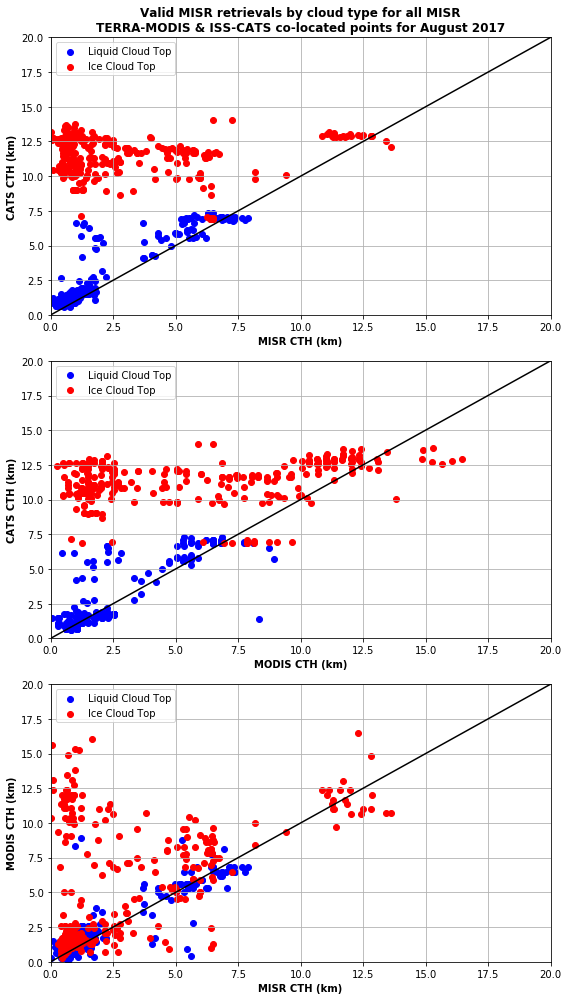

In [52]:
import numpy as np
import matplotlib.pyplot as plt

A = np.loadtxt('CATS_MODIS_coincidence_backscatter_statitics_Aug_2017')
ice_cl = A[np.where(A[:,5]==3)]
CATS_ice_cth = ice_cl[:,1]
MISR_ice_cth = ice_cl[:,3]
MODIS_ice_cth = ice_cl[:,4]
liq_cl = A[np.where(A[:,5]==1)]
CATS_liq_cth = liq_cl[:,1]
MISR_liq_cth = liq_cl[:,3]
MODIS_liq_cth = liq_cl[:,4]
x=np.linspace(0,20,20)


fig,(ax1,ax2,ax3)=plt.subplots(nrows=3,ncols=1,figsize=(8,14))
ax1.scatter(MISR_liq_cth,CATS_liq_cth,color='b',label='Liquid Cloud Top')
ax1.scatter(MISR_ice_cth,CATS_ice_cth,color='r',label='Ice Cloud Top')
ax1.plot(x,x,'k')
ax1.legend()
ax1.set_xlim(0,20)
ax1.set_ylim(0,20)
ax1.set_xlabel('MISR CTH (km)',size=10,weight='bold')
ax1.set_ylabel('CATS CTH (km)',size=10,weight='bold')
ax1.set_title('Valid MISR retrievals by cloud type for all MISR'+'\n'+'TERRA-MODIS & ISS-CATS co-located points for August 2017', weight='bold')
ax1.grid()

ax2.scatter(MODIS_liq_cth,CATS_liq_cth,color='b',label='Liquid Cloud Top')
ax2.scatter(MODIS_ice_cth,CATS_ice_cth,color='r',label='Ice Cloud Top')
ax2.plot(x,x,'k')
ax2.legend()
ax2.set_xlim(0,20)
ax2.set_ylim(0,20)
ax2.set_xlabel('MODIS CTH (km)',size=10,weight='bold')
ax2.set_ylabel('CATS CTH (km)',size=10,weight='bold')
ax2.grid()

ax3.scatter(MISR_liq_cth,MODIS_liq_cth,color='b',label='Liquid Cloud Top')
ax3.scatter(MISR_ice_cth,MODIS_ice_cth,color='r',label='Ice Cloud Top')
ax3.plot(x,x,'k')
ax3.legend()
ax3.set_xlim(0,20)
ax3.set_ylim(0,20)
ax3.set_xlabel('MISR CTH (km)',size=10,weight='bold')
ax3.set_ylabel('MODIS CTH (km)',size=10,weight='bold')
ax3.grid()

plt.tight_layout()
plt.show()

(-0.0057097934, 0.15083528)
(-3.7800010000000004, 14.198999)
(-1.5090009999999996, 13.164999)
(-0.0057097934, 0.15083528)
(-6.970000799999999, 5.798998999999999)
(-0.9510018000000002, 5.6370000000000005)


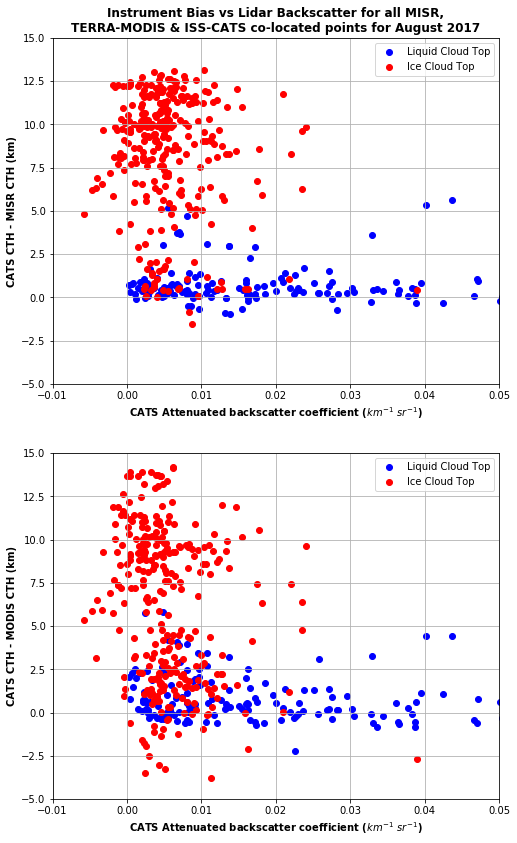

In [77]:
import numpy as np
import matplotlib.pyplot as plt

A = np.loadtxt('CATS_MODIS_coincidence_backscatter_statitics_Aug_2017')
ice_cl = A[np.where(A[:,5]==3)]
CATS_ice_cth = ice_cl[:,1]
MISR_ice_cth = ice_cl[:,3]
MODIS_ice_cth = ice_cl[:,4]
CATS_ice_scatter = ice_cl[:,0]
MODIS_ice_bias = CATS_ice_cth-MODIS_ice_cth
MISR_ice_bias = CATS_ice_cth-MISR_ice_cth
print(np.min(CATS_ice_scatter),np.max(CATS_ice_scatter))
print(np.min(MODIS_ice_bias),np.max(MODIS_ice_bias))
print(np.min(MISR_ice_bias),np.max(MISR_ice_bias))

liq_cl = A[np.where(A[:,5]==1)]
CATS_liq_cth = liq_cl[:,1]
MISR_liq_cth = liq_cl[:,3]
MODIS_liq_cth = liq_cl[:,4]
CATS_liq_scatter = liq_cl[:,0]
MODIS_liq_bias = CATS_liq_cth-MODIS_liq_cth
MISR_liq_bias = CATS_liq_cth-MISR_liq_cth
print(np.min(CATS_ice_scatter),np.max(CATS_ice_scatter))
print(np.min(MODIS_liq_bias),np.max(MODIS_liq_bias))
print(np.min(MISR_liq_bias),np.max(MISR_liq_bias))

fig,(ax1,ax2)=plt.subplots(nrows=2,ncols=1,figsize=(8,14))
ax1.scatter(CATS_liq_scatter,MISR_liq_bias,color='b',label='Liquid Cloud Top')
ax1.scatter(CATS_ice_scatter,MISR_ice_bias,color='r',label='Ice Cloud Top')
ax1.legend()
#ax1.set_xscale('log')
ax1.set_xlim(-0.01,0.05)
ax1.set_ylim(-5,15)
ax1.set_xlabel('CATS Attenuated backscatter coefficient ($km^{-1}$ $sr^{-1}$)',size=10,weight='bold')
ax1.set_ylabel('CATS CTH - MISR CTH (km)',size=10,weight='bold')
ax1.set_title('Instrument Bias vs Lidar Backscatter for all MISR,'+'\n'+'TERRA-MODIS & ISS-CATS co-located points for August 2017', weight='bold')
ax1.grid()

ax2.scatter(CATS_liq_scatter,MODIS_liq_bias,color='b',label='Liquid Cloud Top')
ax2.scatter(CATS_ice_scatter,MODIS_ice_bias,color='r',label='Ice Cloud Top')
ax2.legend()
#ax1.set_xscale('log')
ax2.set_xlim(-0.01,0.05)
ax2.set_ylim(-5,15)
ax2.set_xlabel('CATS Attenuated backscatter coefficient ($km^{-1}$ $sr^{-1}$)',size=10,weight='bold')
ax2.set_ylabel('CATS CTH - MODIS CTH (km)',size=10,weight='bold')
#ax2.set_title('Valid MISR retrievals by cloud type for all MISR'+'\n'+'TERRA-MODIS & ISS-CATS co-located points for August 2017', weight='bold')
ax2.grid()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

A1 = np.loadtxt('CATS_MODIS_coincidence_backscatter_statitics_Aug_2017')
ice_cl = A[np.where(A[:,5]==3)]
CATS_ice_cth = ice_cl[:,1]
MISR_ice_cth = ice_cl[:,3]
MODIS_ice_cth = ice_cl[:,4]
liq_cl = A[np.where(A[:,5]==1)]
CATS_liq_cth = liq_cl[:,1]
MISR_liq_cth = liq_cl[:,3]
MODIS_liq_cth = liq_cl[:,4]
x=np.linspace(0,20,20)


fig,(ax1,ax2,ax3)=plt.subplots(nrows=3,ncols=1,figsize=(8,14))
ax1.scatter(MISR_liq_cth,CATS_liq_cth,color='b',label='Liquid Cloud Top')
ax1.scatter(MISR_ice_cth,CATS_ice_cth,color='r',label='Ice Cloud Top')
ax1.plot(x,x,'k')
ax1.legend()
ax1.set_xlim(0,20)
ax1.set_ylim(0,20)
ax1.set_xlabel('MISR CTH (km)',size=10,weight='bold')
ax1.set_ylabel('CATS CTH (km)',size=10,weight='bold')
ax1.set_title('Valid MISR retrievals by cloud type for all MISR'+'\n'+'TERRA-MODIS & ISS-CATS co-located points for August 2017', weight='bold')
ax1.grid()

ax2.scatter(MODIS_liq_cth,CATS_liq_cth,color='b',label='Liquid Cloud Top')
ax2.scatter(MODIS_ice_cth,CATS_ice_cth,color='r',label='Ice Cloud Top')
ax2.plot(x,x,'k')
ax2.legend()
ax2.set_xlim(0,20)
ax2.set_ylim(0,20)
ax2.set_xlabel('MODIS CTH (km)',size=10,weight='bold')
ax2.set_ylabel('CATS CTH (km)',size=10,weight='bold')
ax2.grid()

ax3.scatter(MISR_liq_cth,MODIS_liq_cth,color='b',label='Liquid Cloud Top')
ax3.scatter(MISR_ice_cth,MODIS_ice_cth,color='r',label='Ice Cloud Top')
ax3.plot(x,x,'k')
ax3.legend()
ax3.set_xlim(0,20)
ax3.set_ylim(0,20)
ax3.set_xlabel('MISR CTH (km)',size=10,weight='bold')
ax3.set_ylabel('MODIS CTH (km)',size=10,weight='bold')
ax3.grid()

plt.tight_layout()
plt.show()